In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta, datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

import statsmodels.api as sm

Using saas.csv or log data from API usage:

In [2]:
# bring in data
df = pd.read_csv('saas.csv')

In [3]:
df.head(3)

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0


In [4]:
df.shape

(790458, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
Month_Invoiced       790458 non-null object
Customer_Id          790458 non-null int64
Invoice_Id           790458 non-null int64
Subscription_Type    790458 non-null float64
Amount               790458 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [6]:
# change Month_Invoiced to datetime
df['Month_Invoiced'] = pd.to_datetime(df['Month_Invoiced'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
Month_Invoiced       790458 non-null datetime64[ns]
Customer_Id          790458 non-null int64
Invoice_Id           790458 non-null int64
Subscription_Type    790458 non-null float64
Amount               790458 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 30.2 MB


In [8]:
df = df.sort_values('Month_Invoiced').set_index('Month_Invoiced')

In [9]:
df.head(3)

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1013336,5013336,0.0,0.0
2014-01-31,1013335,5013335,0.0,0.0


In [10]:
df.tail(3)

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2017-12-31,1012074,5781187,1.0,5.0
2017-12-31,1012047,5781176,3.0,15.0
2017-12-31,1029399,5790457,0.0,0.0


In [11]:
df.drop(columns=['Customer_Id', 'Invoice_Id', 'Subscription_Type'],inplace=True)

In [12]:
df.head(3)

,Amount
Month_Invoiced,
2014-01-31,0.0
2014-01-31,0.0
2014-01-31,0.0


In [13]:
# Resample 'Month_Invoiced' by day (best practice), then adjust accordingly
df = df.resample("M").sum()
df

,Amount
Month_Invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0
2014-06-30,41255.0
2014-07-31,42170.0
2014-08-31,43210.0
2014-09-30,44075.0


In [14]:
df.shape

(48, 1)

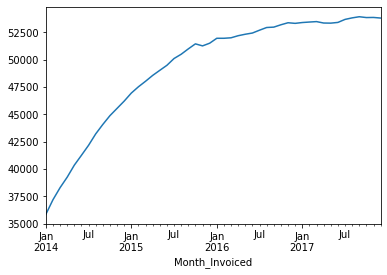

In [16]:
# Look at distributions
df.Amount.plot()

In [17]:
# reset the index to split the data
df = df.reset_index()
df.head(3)

,Month_Invoiced,Amount
0,2014-01-31,35850.0
1,2014-02-28,37190.0
2,2014-03-31,38295.0


In [18]:
# establish an x and y
x = df['Month_Invoiced']
y = df['Amount']

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [33]:
def split_store_data(df, train_prop=.70):
    train_size = int(len(df) * train_prop)
    train, test = df[0:train_size], df[train_size:len(df)]
    return train, test

In [34]:
train, test = split_store_data(df)
display(train, test)

,Month_Invoiced,Amount
0,2014-01-31,35850.0
1,2014-02-28,37190.0
2,2014-03-31,38295.0
3,2014-04-30,39255.0
4,2014-05-31,40355.0
5,2014-06-30,41255.0
6,2014-07-31,42170.0
7,2014-08-31,43210.0
8,2014-09-30,44075.0
9,2014-10-31,44880.0


,Month_Invoiced,Amount
33,2016-10-31,53190.0
34,2016-11-30,53375.0
35,2016-12-31,53320.0
36,2017-01-31,53395.0
37,2017-02-28,53440.0
38,2017-03-31,53480.0
39,2017-04-30,53350.0
40,2017-05-31,53340.0
41,2017-06-30,53405.0
42,2017-07-31,53680.0


In [35]:
print("Observations:",len(df))
print("Train:",len(train))
print("Test:",len(test))

Observations: 48
Train: 33
Test: 15


In [36]:
train = train.set_index('Month_Invoiced')
test = test.set_index('Month_Invoiced')

In [39]:
train.tail(3)

,Amount
Month_Invoiced,
2016-07-31,52695.0
2016-08-31,52940.0
2016-09-30,52975.0


In [38]:
test.head(3)

,Amount
Month_Invoiced,
2016-10-31,53190.0
2016-11-30,53375.0
2016-12-31,53320.0


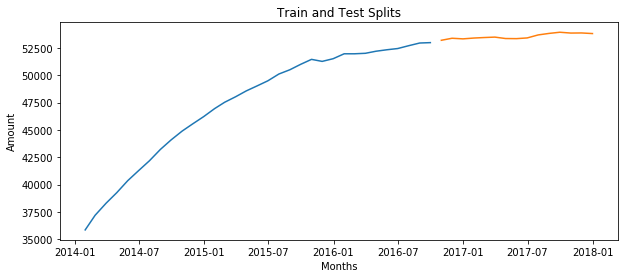

In [41]:
plt.figure(figsize=(10,4))
plt.plot(train)
plt.plot(test)
plt.xlabel('Months')
plt.ylabel('Amount')
plt.title('Train and Test Splits')
plt.show()

2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - Simple Average
    - Moving Average
    - Holt's Linear Trend Model
    - Based on previous year/month/etc., this is up to you.

In [42]:
# Evaluate the mse and rmse
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

In [43]:
# plot the evals
def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train', linewidth=1)
    plt.plot(test[target_vars], label='Test', linewidth=1)

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

In [44]:
# Created an empty df to hold future information
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'metric', 'value'])
eval_df

,model_type,target_var,metric,value


In [45]:
# Append each variable to the new df to look at everything together
def append_eval_df(model_type, target_vars, train = train, test = test):
    temp_eval_df = pd.concat([pd.DataFrame([[model_type, i, 'mse', evaluate(target_var = i, 
                                                                            train = train, 
                                                                            test = test, 
                                                                            output=False)[0]],
                                            [model_type, i, 'rmse', evaluate(target_var = i, 
                                                                             train = train, 
                                                                             test = test, 
                                                                             output=False)[1]]],
                                           columns=['model_type', 'target_var', 'metric', 'value']) 
                              for i in target_vars], ignore_index=True)
    return eval_df.append(temp_eval_df, ignore_index=True)

In [46]:
# Last Observed Values
yhat = pd.DataFrame(test['Amount'])

In [47]:
yhat

,Amount
Month_Invoiced,
2016-10-31,53190.0
2016-11-30,53375.0
2016-12-31,53320.0
2017-01-31,53395.0
2017-02-28,53440.0
2017-03-31,53480.0
2017-04-30,53350.0
2017-05-31,53340.0
2017-06-30,53405.0


In [ ]:
for var in 